# Trabajo Práctico 5 - Procesamiento de Imágenes
- Francisco Devaux
- Agustín Yornet

## Ejercicio 3
> Umbralización híbrida (combinación de Otsu + morfología). ¿Cómo mejorar la segmentación
de objetos con ruido o regiones conectadas? Práctica sugerida: Aplicar Otsu, luego refinar con
cv2.morphologyEx() (apertura o cierre).

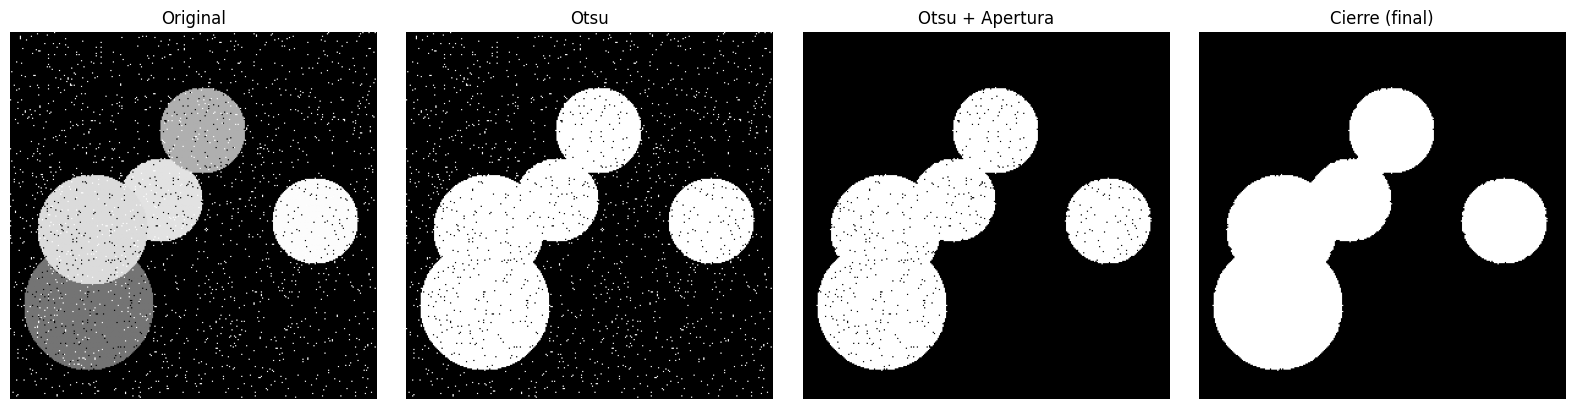

In [18]:
import cv2
import matplotlib.pyplot as plt

img = cv2.imread('./imagenes/img_grises2_ruido.png', cv2.IMREAD_GRAYSCALE)

_, otsu_thresh = cv2.threshold(img, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)

kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (3, 3))

apertura = cv2.morphologyEx(otsu_thresh, cv2.MORPH_OPEN, kernel)
cierre = cv2.morphologyEx(apertura, cv2.MORPH_CLOSE, kernel)

plt.figure(figsize=(16, 4))

titles = ['Original', 'Otsu', 'Otsu + Apertura', 'Cierre (final)']
images = [img, otsu_thresh, apertura, cierre]

for i in range(4):
    plt.subplot(1, 4, i+1)
    plt.imshow(images[i], cmap='gray')
    plt.title(titles[i])
    plt.axis('off')

plt.tight_layout()
plt.show()

## Ejercicio 4

> Segmentación por detección de bordes. ¿Cómo se puede usar la información de bordes para
segmentar una imagen? Práctica sugerida: Detectar bordes con cv2.Canny() o skimage.filters.sobel,
luego aplicar umbral y cerrar regiones con morfología.

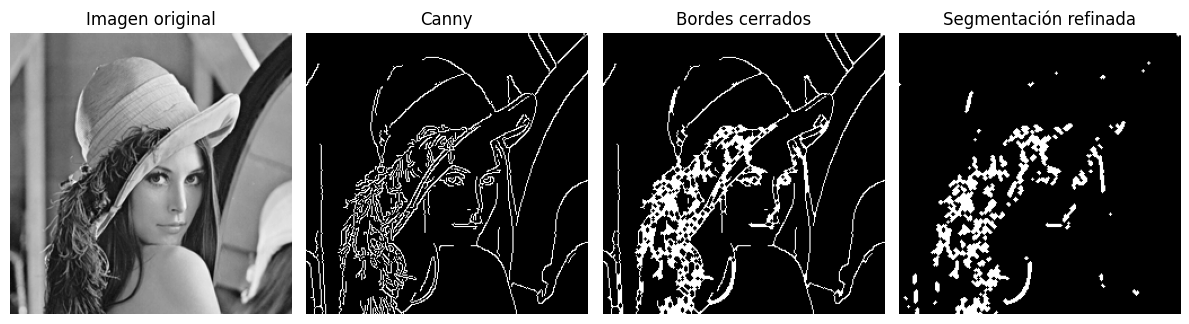

In [69]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

# Cargar la imagen en escala de grises
imagen = cv2.imread("./imagenes/Lenna.png", cv2.IMREAD_GRAYSCALE)

# 1. Detección de bordes con Canny
bordes = cv2.Canny(imagen, threshold1=100, threshold2=220)

#mostramos la imagen original y los bordes detectados
# 2. Operación de cierre para unir bordes rotos
kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (3, 3))
bordes_cerrados = cv2.morphologyEx(bordes, cv2.MORPH_CLOSE, kernel)

# 3. Umbralización (no estrictamente necesario si ya son bordes binarios)
_, umbral = cv2.threshold(bordes_cerrados, 1, 255, cv2.THRESH_BINARY)

# 4. Opcional: Refinar con dilatación o apertura si es necesario
refinado = cv2.morphologyEx(umbral, cv2.MORPH_OPEN, kernel)

# Mostrar resultados sin ejes
fig, axs = plt.subplots(1, 4, figsize=(12, 4))
imagenes = [imagen, bordes, bordes_cerrados, refinado]
titulos = ['Imagen original', "Canny", 'Bordes cerrados', 'Segmentación refinada']

for i in range(4):
    axs[i].imshow(imagenes[i], cmap='gray')
    axs[i].set_title(titulos[i])
    axs[i].axis('off')

plt.tight_layout()
plt.show()